# for each gage, filter by bfd == 1

In [55]:
import pandas as pd
import os

# from main_jupyter import final_measurements_delta

# Define the directory containing the CSV files
directory = 'GSLB_ML'

# Initialize an empty DataFrame to store the results
compiled_data = pd.DataFrame(columns=['gage_id', 'date', 'q', 'bfd'])

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Filter rows where ML_BFD is 1
        filtered_df = df[df['ML_BFD'] == 1]

        # Extract gage_id from the filename (assuming filename is the gage_id)
        gage_id = os.path.splitext(filename)[0]

        # Add a new column for gage_id
        filtered_df['gage_id'] = gage_id

        # Select and rename the necessary columns
        filtered_df = filtered_df[['gage_id', 'date','Q', 'ML_BFD']]
        filtered_df.columns = ['gage_id', 'date', 'q', 'bfd']

        # Append to the compiled DataFrame
        compiled_data = pd.concat([compiled_data, filtered_df], ignore_index=True)

# Display the compiled DataFrame
compiled_data


,gage_id,date,q,bfd
0,10015900,1958-04-01,0.0,1.0
1,10015900,1958-04-02,0.0,1.0
2,10015900,1958-04-03,0.0,1.0
3,10015900,1958-04-04,0.0,1.0
4,10015900,1958-04-05,0.0,1.0
...,...,...,...,...
900051,10058600,1986-09-10,35.0,1.0
900052,10058600,1986-09-14,33.6,1.0
900053,10058600,1986-09-24,32.9,1.0
900054,10058600,1986-09-25,34.4,1.0


## q的异常值处理

In [56]:
import pandas as pd

import numpy as np
from scipy import stats

class SimpleOutlierDetector:
    """简化的异常值检测类"""

    def __init__(self, data, column):
        self.data = data.copy()
        self.column = column
        self.results = None

    def detect_outliers(self, zscore_threshold=3.0, iqr_multiplier=1.5):
        """检测异常值"""
        data = self.data.copy()

        # 初始化异常值标记列
        data['is_outlier_zscore'] = False
        data['is_outlier_iqr'] = False

        # 1. Z-score方法
        try:
            z_scores = np.abs(stats.zscore(data[self.column], nan_policy='omit'))
            data['is_outlier_zscore'] = z_scores > zscore_threshold
        except:
            pass

        # 2. IQR方法
        try:
            Q1 = np.nanpercentile(data[self.column], 25)
            Q3 = np.nanpercentile(data[self.column], 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            data['is_outlier_iqr'] = (data[self.column] < lower_bound) | (data[self.column] > upper_bound)
        except:
            pass

        # 综合异常值判断
        data['is_outlier_any'] = data[['is_outlier_zscore', 'is_outlier_iqr']].any(axis=1)

        self.results = data
        return self.results

    def get_clean_data(self):
        """获取清洁数据"""
        if self.results is None:
            raise ValueError("请先运行 detect_outliers() 方法")
        return self.results[~self.results['is_outlier_any']].copy()

# 使用示例
detector = SimpleOutlierDetector(compiled_data, 'q')
outlier_results = detector.detect_outliers()
clean_data = detector.get_clean_data()

# 显示清洁数据
print(clean_data.head())


    gage_id        date    q  bfd  is_outlier_zscore  is_outlier_iqr  \
0  10015900  1958-04-01  0.0  1.0              False           False   
1  10015900  1958-04-02  0.0  1.0              False           False   
2  10015900  1958-04-03  0.0  1.0              False           False   
3  10015900  1958-04-04  0.0  1.0              False           False   
4  10015900  1958-04-05  0.0  1.0              False           False   

   is_outlier_any  
0           False  
1           False  
2           False  
3           False  
4           False  


In [57]:
# 获取检测结果
outlier_results = detector.detect_outliers()

# 查看被标记为异常的数据点数量
total_outliers = outlier_results['is_outlier_any'].sum()
print(f"检测出的异常值数量：{total_outliers}")

# 查看各种方法检测出的异常值数量
zscore_outliers = outlier_results['is_outlier_zscore'].sum()
iqr_outliers = outlier_results['is_outlier_iqr'].sum()

print(f"Z-score方法检测出的异常值数量：{zscore_outliers}")
print(f"IQR方法检测出的异常值数量：{iqr_outliers}")

检测出的异常值数量：35377
Z-score方法检测出的异常值数量：14340
IQR方法检测出的异常值数量：35377


In [58]:
# 获取检测结果
outlier_results = detector.detect_outliers()

# 标记两种方法都检测为异常的记录
outlier_results['is_outlier_both'] = outlier_results['is_outlier_zscore'] & outlier_results['is_outlier_iqr']

# 去掉两种方法都检测出的异常值
clean_data = outlier_results[~outlier_results['is_outlier_both']].copy()

# 显示清理后的记录数和被去掉的异常值数
removed_count = outlier_results['is_outlier_both'].sum()
print(f"已去掉两种方法都检测出的异常值数量：{removed_count}")
print(f"清理后的记录数：{len(clean_data)}")

已去掉两种方法都检测出的异常值数量：14340
清理后的记录数：885716


In [61]:
clean_data=clean_data[['gage_id','date','q','bfd']]

In [62]:
clean_data.head()

,gage_id,date,q,bfd
0,10015900,1958-04-01,0.0,1.0
1,10015900,1958-04-02,0.0,1.0
2,10015900,1958-04-03,0.0,1.0
3,10015900,1958-04-04,0.0,1.0
4,10015900,1958-04-05,0.0,1.0


In [63]:
compiled_data=clean_data.copy()

In [64]:
# Define the output directory
output_directory = 'base_on_bfd_1'
os.makedirs(output_directory, exist_ok=True)

# Define the output file path
output_file_path = os.path.join(output_directory, 'q_bfd_1.csv')

# Save the compiled DataFrame to a CSV file
compiled_data.to_csv(output_file_path, index=False)

# Display the path where the file is saved
output_file_path

'base_on_bfd_1/q_bfd_1.csv'

In [65]:
compiled_data=pd.read_csv('base_on_bfd_1/q_bfd_1.csv')

## pchip well data

In [2]:
import pandas as pd

In [67]:
well_ts = pd.read_csv('base_on_bfd_1/prep/GSLB_1900-2023_TS_with_aquifers.csv')

In [68]:
well_ts.head()

,AquiferID,Well_ID,Date,WTE,State
0,1,381033113480701,2012-09-06,7092.99,UT
1,1,381037113474001,2012-09-06,7175.95,UT
2,1,381152113442801,1995-11-22,6200.00,UT
3,1,381236113485601,2014-07-23,7151.00,UT
4,1,382113113435401,2008-09-03,5395.95,UT


In [69]:
well_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177209 entries, 0 to 177208
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AquiferID  177209 non-null  int64  
 1   Well_ID    177209 non-null  int64  
 2   Date       177209 non-null  object 
 3   WTE        177209 non-null  float64
 4   State      177209 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 6.8+ MB


### 异常值处理

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图形参数
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')

class SimpleGroundwaterOutlierDetector:
    """简化的地下水数据异常值检测类 - 仅基于井内统计学方法"""

    def __init__(self, data):
        self.data = data.copy()
        self.results = None

    def preprocess_data(self):
        """数据预处理"""
        # 转换日期格式
        self.data['Date'] = pd.to_datetime(self.data['Date'])

        # 按井点和时间排序
        self.data = self.data.sort_values(['Well_ID', 'Date']).reset_index(drop=True)

        print("数据预处理完成")
        print(f"数据基本信息:")
        print(f"- 总记录数: {len(self.data):,}")
        print(f"- 井点数量: {self.data['Well_ID'].nunique()}")
        print(f"- 含水层数量: {self.data['AquiferID'].nunique()}")
        print(f"- 时间范围: {self.data['Date'].min()} 到 {self.data['Date'].max()}")
        print(f"- WTE统计: 均值{self.data['WTE'].mean():.2f}, 标准差{self.data['WTE'].std():.2f}")

    def detect_outliers_by_well(self, min_points_for_stats=5,
                               zscore_threshold=3.0,
                               iqr_multiplier=2,
                               modified_zscore_threshold=3.5):
        """
        按井点检测异常值

        参数:
        - min_points_for_stats: 进行统计检验的最少数据点数
        - zscore_threshold: Z-score阈值
        - iqr_multiplier: IQR倍数
        - modified_zscore_threshold: 修正Z-score阈值
        """

        results = []
        well_summary = []

        for well_id in self.data['Well_ID'].unique():
            well_data = self.data[self.data['Well_ID'] == well_id].copy().sort_values('Date')
            n_points = len(well_data)

            # 初始化异常值标记列
            well_data['is_outlier_zscore'] = False
            well_data['is_outlier_iqr'] = False
            well_data['is_outlier_modified_zscore'] = False
            well_data['is_outlier_physical'] = False
            well_data['zscore'] = 0
            well_data['modified_zscore'] = 0

            # 基本物理检查（适用于所有井）
            well_data['is_outlier_physical'] = False

            # 统计学检验（只对数据点足够多的井进行）
            if n_points >= min_points_for_stats:
                wte_values = well_data['WTE'].values

                # 1. Z-score方法
                try:
                    z_scores = np.abs(stats.zscore(wte_values, nan_policy='omit'))
                    well_data['zscore'] = z_scores
                    well_data['is_outlier_zscore'] = z_scores > zscore_threshold
                except:
                    pass

                # 2. IQR方法
                try:
                    Q1 = np.nanpercentile(wte_values, 25)
                    Q3 = np.nanpercentile(wte_values, 75)
                    IQR = Q3 - Q1
                    if IQR > 0:  # 避免除零错误
                        lower_bound = Q1 - iqr_multiplier * IQR
                        upper_bound = Q3 + iqr_multiplier * IQR
                        well_data['is_outlier_iqr'] = (wte_values < lower_bound) | (wte_values > upper_bound)
                except:
                    pass

                # 3. 修正Z-score方法（基于中位数，更稳健）
                try:
                    median = np.nanmedian(wte_values)
                    mad = np.nanmedian(np.abs(wte_values - median))
                    if mad > 0:  # 避免除零错误
                        modified_z_scores = 0.6745 * (wte_values - median) / mad
                        well_data['modified_zscore'] = np.abs(modified_z_scores)
                        well_data['is_outlier_modified_zscore'] = np.abs(modified_z_scores) > modified_zscore_threshold
                except:
                    pass

            # 综合异常值判断
            outlier_cols = ['is_outlier_zscore', 'is_outlier_iqr', 'is_outlier_modified_zscore', 'is_outlier_physical']
            well_data['is_outlier_any'] = well_data[outlier_cols].any(axis=1)
            well_data['outlier_method_count'] = well_data[outlier_cols].sum(axis=1)

            # 统计该井的情况
            n_outliers = well_data['is_outlier_any'].sum()
            outlier_rate = n_outliers / n_points * 100 if n_points > 0 else 0

            well_summary.append({
                'Well_ID': well_id,
                'AquiferID': well_data['AquiferID'].iloc[0],
                'State': well_data['State'].iloc[0],
                'n_points': n_points,
                'n_outliers': n_outliers,
                'outlier_rate': outlier_rate,
                'wte_mean': well_data['WTE'].mean(),
                'wte_std': well_data['WTE'].std(),
                'wte_min': well_data['WTE'].min(),
                'wte_max': well_data['WTE'].max(),
                'statistical_methods_applied': n_points >= min_points_for_stats
            })

            results.append(well_data)

        # 合并所有结果
        self.results = pd.concat(results, ignore_index=True)
        self.well_summary = pd.DataFrame(well_summary)

        return self.results, self.well_summary

    def generate_report(self):
        """生成检测报告"""
        if self.results is None:
            print("请先运行 detect_outliers_by_well() 方法")
            return

        print("="*70)
        print("地下水数据异常值检测报告 (基于井内统计学方法)")
        print("="*70)

        # 总体统计
        total_records = len(self.results)
        total_wells = self.results['Well_ID'].nunique()
        total_outliers = self.results['is_outlier_any'].sum()

        print(f"\n总体统计:")
        print(f"- 总记录数: {total_records:,}")
        print(f"- 总井点数: {total_wells:,}")
        print(f"- 总异常值: {total_outliers:,} ({total_outliers/total_records*100:.2f}%)")

        # 按井点数据量分组统计
        print(f"\n按井点数据量分组:")
        data_count_groups = [
            (1, 2, "1-2个数据点"),
            (3, 5, "3-5个数据点"),
            (6, 10, "6-10个数据点"),
            (11, 50, "11-50个数据点"),
            (51, float('inf'), "50+个数据点")
        ]

        for min_count, max_count, label in data_count_groups:
            if max_count == float('inf'):
                mask = self.well_summary['n_points'] >= min_count
            else:
                mask = (self.well_summary['n_points'] >= min_count) & (self.well_summary['n_points'] <= max_count)

            group_wells = self.well_summary[mask]
            n_wells = len(group_wells)
            n_records = group_wells['n_points'].sum()
            n_outliers = group_wells['n_outliers'].sum()

            if n_wells > 0:
                avg_outlier_rate = group_wells['outlier_rate'].mean()
                print(f"- {label}: {n_wells}个井, {n_records}条记录, {n_outliers}个异常值 (平均异常率: {avg_outlier_rate:.1f}%)")

        # 检测方法统计
        print(f"\n各检测方法结果:")
        methods = {
            'Z-score方法': 'is_outlier_zscore',
            'IQR方法': 'is_outlier_iqr',
            '修正Z-score方法': 'is_outlier_modified_zscore',
            '物理约束检查': 'is_outlier_physical'
        }

        for method_name, col_name in methods.items():
            if col_name in self.results.columns:
                count = self.results[col_name].sum()
                percentage = count / total_records * 100
                print(f"- {method_name}: {count:,} ({percentage:.2f}%)")

        # 多方法检测统计
        print(f"\n多方法交叉验证:")
        method_count_dist = self.results['outlier_method_count'].value_counts().sort_index()
        for count, freq in method_count_dist.items():
            if count > 0:
                percentage = freq / total_records * 100
                print(f"- 被{count}种方法识别: {freq:,} ({percentage:.2f}%)")

        # 问题井点识别（异常率过高的井）
        high_outlier_wells = self.well_summary[
            (self.well_summary['outlier_rate'] > 20) &
            (self.well_summary['n_points'] >= 5)
        ].sort_values('outlier_rate', ascending=False)

        if len(high_outlier_wells) > 0:
            print(f"\n需要关注的井点 (异常率>20%且数据点≥5):")
            for _, well in high_outlier_wells.head(10).iterrows():
                print(f"- 井点{well['Well_ID']}: {well['n_points']}个数据点, 异常率{well['outlier_rate']:.1f}%")

        # PCHIP插值友好性分析
        print(f"\nPCHIP插值适用性分析:")
        wells_with_few_points = self.well_summary[self.well_summary['n_points'] <= 2]
        wells_with_high_outlier_rate = self.well_summary[
            (self.well_summary['outlier_rate'] > 50) &
            (self.well_summary['n_points'] <= 5)
        ]

        print(f"- 数据点≤2的井: {len(wells_with_few_points)}个 (PCHIP无法插值)")
        print(f"- 数据点少且异常率高的井: {len(wells_with_high_outlier_rate)}个 (需要人工检查)")

        usable_wells = len(self.well_summary[
            (self.well_summary['n_points'] >= 3) &
            (self.well_summary['outlier_rate'] <= 50)
        ])
        print(f"- 适合直接插值的井: {usable_wells}个")

    def visualize_results(self, sample_wells=6, figsize=(16, 12)):
        """可视化检测结果"""
        if self.results is None:
            print("请先运行 detect_outliers_by_well() 方法")
            return

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('地下水异常值检测结果可视化', fontsize=16)

        # 1. 随机选择几个井点显示时间序列
        ax1 = axes[0, 0]
        sample_well_ids = np.random.choice(
            self.results['Well_ID'].unique(),
            min(sample_wells, self.results['Well_ID'].nunique()),
            replace=False
        )

        colors = plt.cm.tab10(np.linspace(0, 1, len(sample_well_ids)))
        for i, well_id in enumerate(sample_well_ids):
            well_data = self.results[self.results['Well_ID'] == well_id].sort_values('Date')

            # 正常点
            normal_data = well_data[~well_data['is_outlier_any']]
            if len(normal_data) > 0:
                ax1.plot(normal_data['Date'], normal_data['WTE'],
                        'o-', color=colors[i], alpha=0.7, markersize=4,
                        label=f'井{well_id}')

            # 异常点
            outlier_data = well_data[well_data['is_outlier_any']]
            if len(outlier_data) > 0:
                ax1.scatter(outlier_data['Date'], outlier_data['WTE'],
                           color='red', s=60, marker='x', alpha=0.8)

        ax1.set_title('时间序列 (红X为异常值)')
        ax1.set_xlabel('日期')
        ax1.set_ylabel('WTE')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)

        # 2. WTE分布对比
        ax2 = axes[0, 1]
        normal_wte = self.results[~self.results['is_outlier_any']]['WTE']
        outlier_wte = self.results[self.results['is_outlier_any']]['WTE']

        ax2.hist(normal_wte, bins=50, alpha=0.7, label='正常值', density=True)
        if len(outlier_wte) > 0:
            ax2.hist(outlier_wte, bins=20, alpha=0.7, label='异常值',
                    density=True, color='red')
        ax2.set_title('WTE值分布对比')
        ax2.set_xlabel('WTE')
        ax2.set_ylabel('密度')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. 各检测方法异常值数量
        ax3 = axes[0, 2]
        methods = ['zscore', 'iqr', 'modified_zscore', 'physical']
        method_counts = []
        method_labels = ['Z-score', 'IQR', '修正Z-score', '物理约束']

        for method in methods:
            col_name = f'is_outlier_{method}'
            if col_name in self.results.columns:
                count = self.results[col_name].sum()
                method_counts.append(count)
            else:
                method_counts.append(0)

        bars = ax3.bar(method_labels, method_counts, color=['skyblue', 'lightgreen', 'orange', 'pink'])
        ax3.set_title('各方法检测异常值数量')
        ax3.set_ylabel('异常值数量')
        ax3.tick_params(axis='x', rotation=45)

        # 添加数值标签
        for bar, count in zip(bars, method_counts):
            if count > 0:
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(method_counts)*0.01,
                        str(count), ha='center', va='bottom')

        # 4. 井点数据量分布
        ax4 = axes[1, 0]
        data_counts = self.well_summary['n_points']
        ax4.hist(data_counts, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
        ax4.set_title('井点数据量分布')
        ax4.set_xlabel('每井数据点数')
        ax4.set_ylabel('井点数量')
        ax4.grid(True, alpha=0.3)

        # 添加统计信息
        ax4.axvline(data_counts.mean(), color='red', linestyle='--',
                   label=f'平均: {data_counts.mean():.1f}')
        ax4.axvline(data_counts.median(), color='green', linestyle='--',
                   label=f'中位数: {data_counts.median():.1f}')
        ax4.legend()

        # 5. 井点异常率分布
        ax5 = axes[1, 1]
        outlier_rates = self.well_summary['outlier_rate']
        ax5.hist(outlier_rates, bins=20, alpha=0.7, color='orange', edgecolor='black')
        ax5.set_title('井点异常率分布')
        ax5.set_xlabel('异常率 (%)')
        ax5.set_ylabel('井点数量')
        ax5.grid(True, alpha=0.3)

        # 6. 数据点数 vs 异常率散点图
        ax6 = axes[1, 2]
        scatter = ax6.scatter(self.well_summary['n_points'],
                             self.well_summary['outlier_rate'],
                             alpha=0.6, s=30)
        ax6.set_title('数据点数 vs 异常率')
        ax6.set_xlabel('数据点数')
        ax6.set_ylabel('异常率 (%)')
        ax6.grid(True, alpha=0.3)

        # 添加趋势线
        if len(self.well_summary) > 1:
            z = np.polyfit(self.well_summary['n_points'], self.well_summary['outlier_rate'], 1)
            p = np.poly1d(z)
            ax6.plot(self.well_summary['n_points'], p(self.well_summary['n_points']),
                    "r--", alpha=0.8, label='趋势线')
            ax6.legend()

        plt.tight_layout()
        plt.show()

        # 显示异常值示例
        if self.results['is_outlier_any'].sum() > 0:
            print("\n异常值示例 (前10个):")
            outlier_examples = self.results[self.results['is_outlier_any']].head(10)
            display_cols = ['Well_ID', 'Date', 'WTE', 'outlier_method_count',
                           'is_outlier_zscore', 'is_outlier_iqr', 'is_outlier_modified_zscore', 'is_outlier_physical']
            available_cols = [col for col in display_cols if col in outlier_examples.columns]
            print(outlier_examples[available_cols].to_string(index=False))
        else:
            print("\n未检测到异常值")

    def get_clean_data_for_interpolation(self, remove_outliers=True):
        """获取适合插值的清洁数据"""
        if self.results is None:
            print("请先运行 detect_outliers_by_well() 方法")
            return None

        if remove_outliers:
            clean_data = self.results[~self.results['is_outlier_any']].copy()
            print(f"移除异常值后剩余 {len(clean_data):,} 条记录")
        else:
            clean_data = self.results.copy()
            print(f"保留所有数据 {len(clean_data):,} 条记录")

        # 统计各井点的数据情况
        well_stats = clean_data.groupby('Well_ID').size().reset_index(columns=['n_points'])

        print(f"\n插值适用性统计:")
        print(f"- 无数据可用的井: {(well_stats['n_points'] == 0).sum()}")
        print(f"- 只有1个数据点的井: {(well_stats['n_points'] == 1).sum()}")
        print(f"- 只有2个数据点的井: {(well_stats['n_points'] == 2).sum()}")
        print(f"- 有3+个数据点的井: {(well_stats['n_points'] >= 3).sum()} (适合PCHIP插值)")

        return clean_data

# 主要使用函数
def analyze_well_outliers(well_ts, min_points_for_stats=50,
                         zscore_threshold=3.0, iqr_multiplier=2):
    """
    分析地下水井数据异常值的主函数

    参数:
    - well_ts: 地下水数据DataFrame
    - min_points_for_stats: 进行统计检验的最少数据点数 (默认5)
    - zscore_threshold: Z-score阈值 (默认3.0)
    - iqr_multiplier: IQR倍数 (默认1.5)
    """

    # 创建检测器
    detector = SimpleGroundwaterOutlierDetector(well_ts)

    # 数据预处理
    detector.preprocess_data()

    # 检测异常值
    print(f"\n开始异常值检测...")
    print(f"- 统计检验最少数据点要求: {min_points_for_stats}")
    print(f"- Z-score阈值: {zscore_threshold}")
    print(f"- IQR倍数: {iqr_multiplier}")

    results, well_summary = detector.detect_outliers_by_well(
        min_points_for_stats=50,
        zscore_threshold=zscore_threshold,
        iqr_multiplier=2
    )

    # 生成报告
    detector.generate_report()

    # 可视化
    detector.visualize_results()

    return detector, results, well_summary

# 使用示例
if __name__ == "__main__":
    print("简化版地下水异常值检测程序")
    print("只使用井内统计学方法，适合PCHIP插值预处理")
    print("\n运行命令:")
    print("detector, results, well_summary = analyze_well_outliers(well_ts)")
    print("\n获取清洁数据用于插值:")
    print("clean_data = detector.get_clean_data_for_interpolation()")

简化版地下水异常值检测程序
只使用井内统计学方法，适合PCHIP插值预处理

运行命令:
detector, results, well_summary = analyze_well_outliers(well_ts)

获取清洁数据用于插值:
clean_data = detector.get_clean_data_for_interpolation()


数据预处理完成
数据基本信息:
- 总记录数: 177,209
- 井点数量: 8602
- 含水层数量: 1
- 时间范围: 1906-01-01 00:00:00 到 2023-12-21 00:00:00
- WTE统计: 均值4630.59, 标准差511.01

开始异常值检测...
- 统计检验最少数据点要求: 50
- Z-score阈值: 3.0
- IQR倍数: 2
地下水数据异常值检测报告 (基于井内统计学方法)

总体统计:
- 总记录数: 177,209
- 总井点数: 8,602
- 总异常值: 3,222 (1.82%)

按井点数据量分组:
- 1-2个数据点: 5664个井, 6491条记录, 0个异常值 (平均异常率: 0.0%)
- 3-5个数据点: 707个井, 2511条记录, 0个异常值 (平均异常率: 0.0%)
- 6-10个数据点: 521个井, 4032条记录, 0个异常值 (平均异常率: 0.0%)
- 11-50个数据点: 1067个井, 26503条记录, 22个异常值 (平均异常率: 0.0%)
- 50+个数据点: 643个井, 137672条记录, 3200个异常值 (平均异常率: 2.8%)

各检测方法结果:
- Z-score方法: 831 (0.47%)
- IQR方法: 2,286 (1.29%)
- 修正Z-score方法: 2,962 (1.67%)
- 物理约束检查: 0 (0.00%)

多方法交叉验证:
- 被1种方法识别: 1,045 (0.59%)
- 被2种方法识别: 1,497 (0.84%)
- 被3种方法识别: 680 (0.38%)

需要关注的井点 (异常率>20%且数据点≥5):
- 井点405916112515301: 61个数据点, 异常率34.4%
- 井点404215112400001: 59个数据点, 异常率33.9%
- 井点405410112541001: 72个数据点, 异常率31.9%
- 井点404105112151501: 59个数据点, 异常率23.7%
- 井点403332111521301: 153个数据点, 异常率22.9%
- 井点413609111495701: 173个数据点, 异常率20.8%
- 井点40584811140370

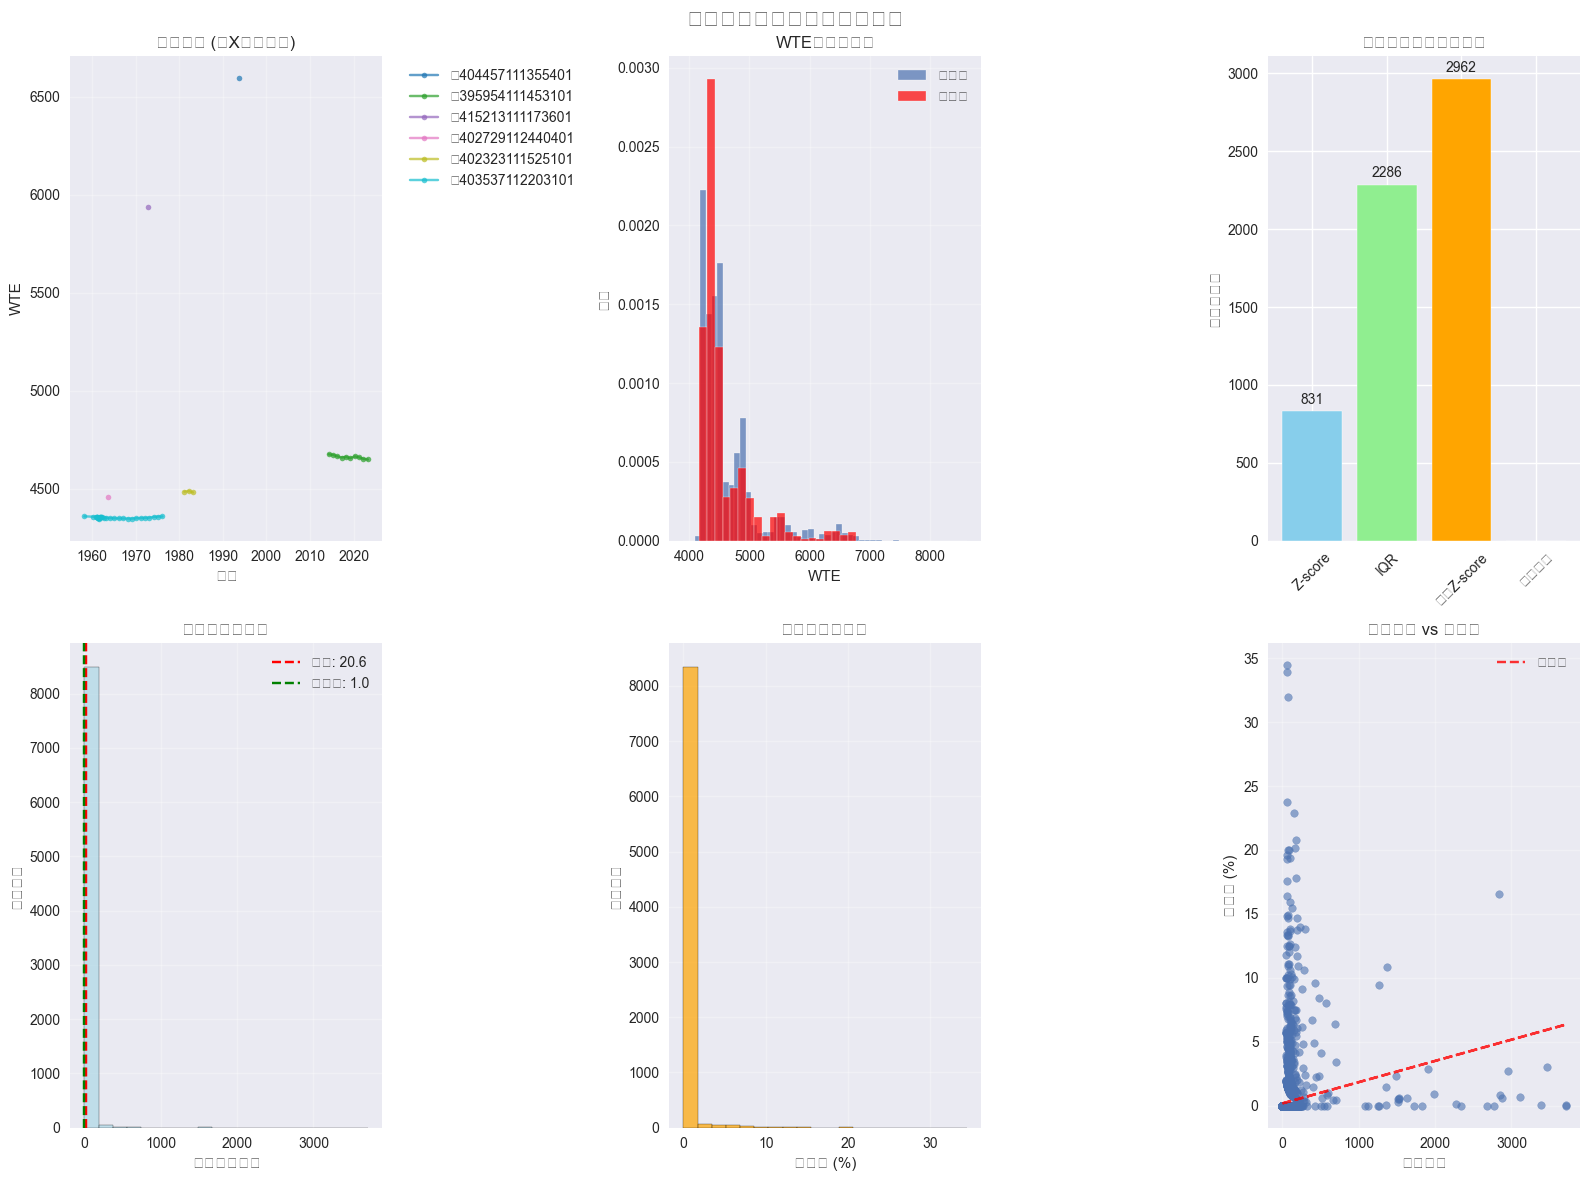


异常值示例 (前10个):
        Well_ID       Date     WTE  outlier_method_count  is_outlier_zscore  is_outlier_iqr  is_outlier_modified_zscore  is_outlier_physical
384702114041601 1999-07-13 5530.10                     2              False            True                        True                False
384702114041601 2006-05-10 5531.21                     3               True            True                        True                False
384714114051001 1981-01-01 5548.00                     2              False            True                        True                False
384714114051001 1991-09-26 5550.92                     1              False            True                       False                False
384714114051001 1992-03-25 5551.15                     2              False            True                        True                False
384714114051001 1998-07-23 5548.70                     2              False            True                        True                Fals

In [71]:
# 基本使用
detector, results, well_summary = analyze_well_outliers(well_ts)

In [11]:
def get_strictly_clean_data(detector):
    """
    从 detector.results 中剔除所有被三种方法都判定为异常的值
    返回 clean_df（已剔除） 和 removed_df（被剔除）
    """
    df = detector.results.copy()

    # 确保这三列存在
    required_cols = ['is_outlier_zscore', 'is_outlier_iqr', 'is_outlier_modified_zscore']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("缺少必要的异常检测列")

    # 三方法全部为 True 的视为强异常
    df['is_strong_outlier'] = df['is_outlier_zscore'] & df['is_outlier_iqr'] & df['is_outlier_modified_zscore']

    # 拆分清洁数据和被剔除数据
    clean_df = df[~df['is_strong_outlier']].copy()
    removed_df = df[df['is_strong_outlier']].copy()

    print(f"强异常值剔除完成：\n- 总共剔除 {len(removed_df):,} 条记录")
    print(f"- 剩余清洁记录 {len(clean_df):,} 条")

    return clean_df, removed_df


数据预处理完成
数据基本信息:
- 总记录数: 177,209
- 井点数量: 8602
- 含水层数量: 1
- 时间范围: 1906-01-01 00:00:00 到 2023-12-21 00:00:00
- WTE统计: 均值4630.59, 标准差511.01

开始异常值检测...
- 统计检验最少数据点要求: 50
- Z-score阈值: 3.0
- IQR倍数: 2
地下水数据异常值检测报告 (基于井内统计学方法)

总体统计:
- 总记录数: 177,209
- 总井点数: 8,602
- 总异常值: 3,222 (1.82%)

按井点数据量分组:
- 1-2个数据点: 5664个井, 6491条记录, 0个异常值 (平均异常率: 0.0%)
- 3-5个数据点: 707个井, 2511条记录, 0个异常值 (平均异常率: 0.0%)
- 6-10个数据点: 521个井, 4032条记录, 0个异常值 (平均异常率: 0.0%)
- 11-50个数据点: 1067个井, 26503条记录, 22个异常值 (平均异常率: 0.0%)
- 50+个数据点: 643个井, 137672条记录, 3200个异常值 (平均异常率: 2.8%)

各检测方法结果:
- Z-score方法: 831 (0.47%)
- IQR方法: 2,286 (1.29%)
- 修正Z-score方法: 2,962 (1.67%)
- 物理约束检查: 0 (0.00%)

多方法交叉验证:
- 被1种方法识别: 1,045 (0.59%)
- 被2种方法识别: 1,497 (0.84%)
- 被3种方法识别: 680 (0.38%)

需要关注的井点 (异常率>20%且数据点≥5):
- 井点405916112515301: 61个数据点, 异常率34.4%
- 井点404215112400001: 59个数据点, 异常率33.9%
- 井点405410112541001: 72个数据点, 异常率31.9%
- 井点404105112151501: 59个数据点, 异常率23.7%
- 井点403332111521301: 153个数据点, 异常率22.9%
- 井点413609111495701: 173个数据点, 异常率20.8%
- 井点40584811140370

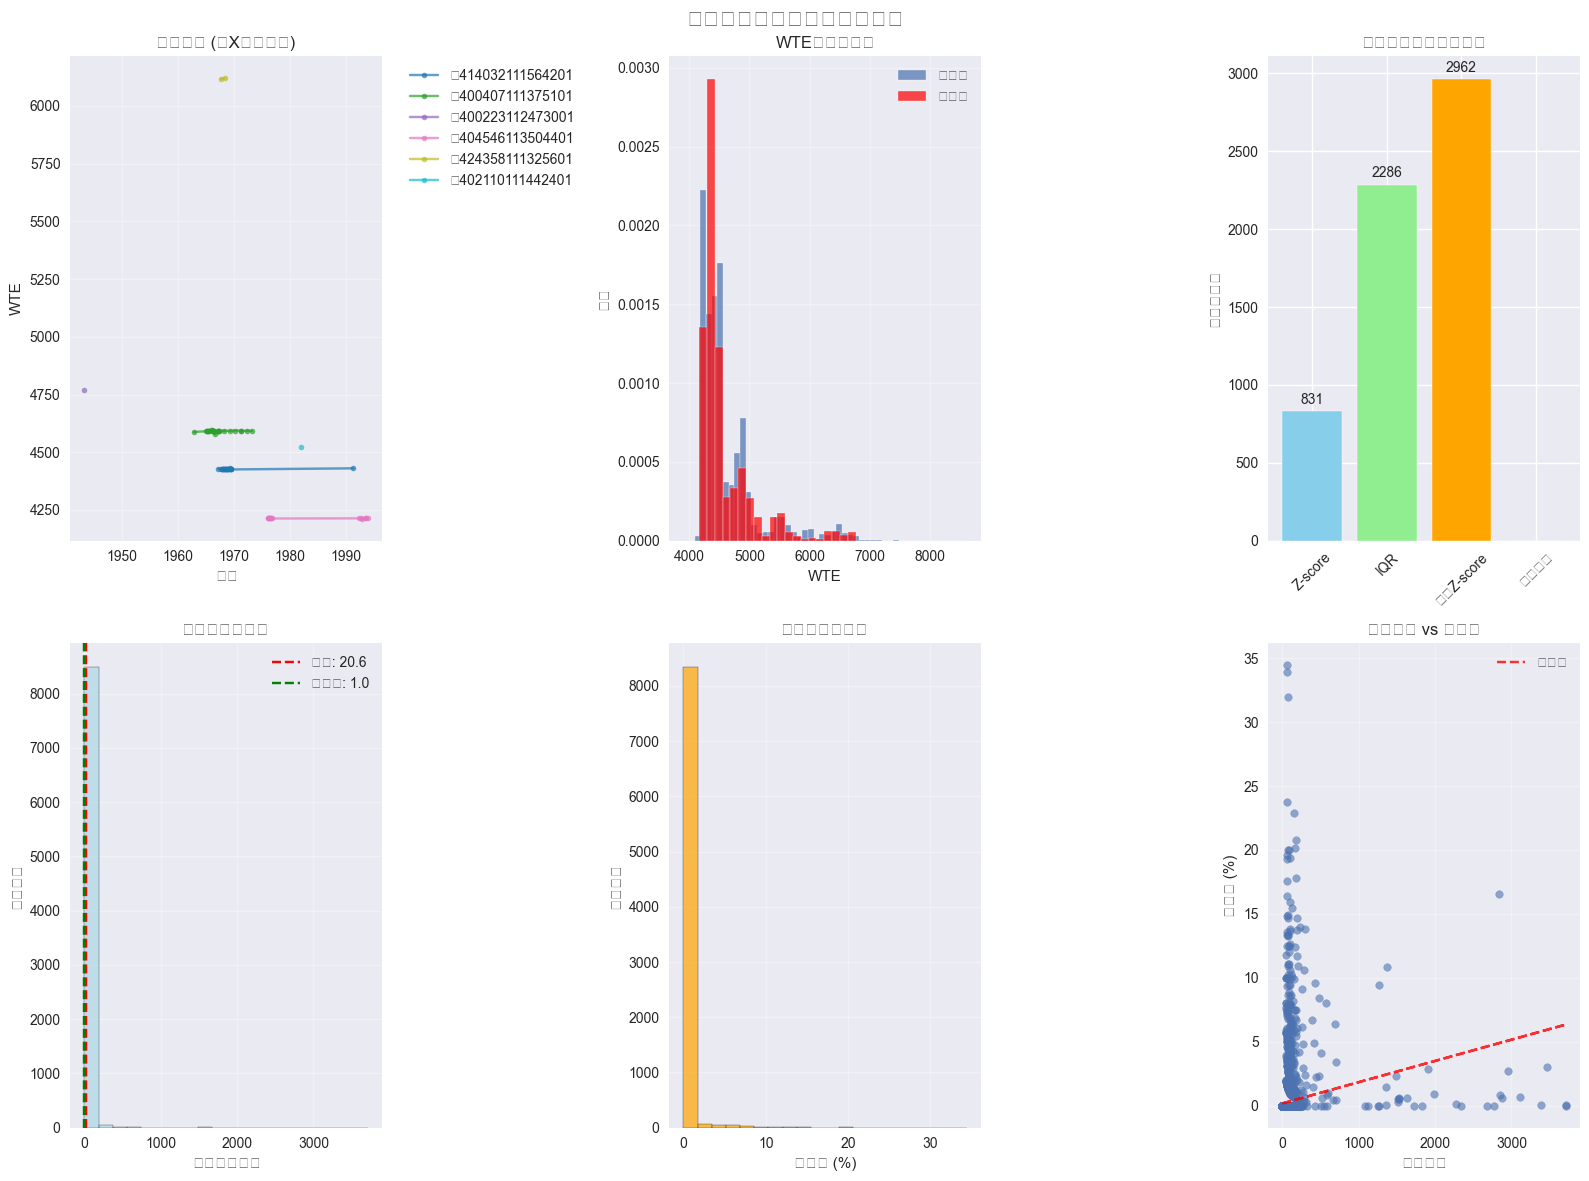


异常值示例 (前10个):
        Well_ID       Date     WTE  outlier_method_count  is_outlier_zscore  is_outlier_iqr  is_outlier_modified_zscore  is_outlier_physical
384702114041601 1999-07-13 5530.10                     2              False            True                        True                False
384702114041601 2006-05-10 5531.21                     3               True            True                        True                False
384714114051001 1981-01-01 5548.00                     2              False            True                        True                False
384714114051001 1991-09-26 5550.92                     1              False            True                       False                False
384714114051001 1992-03-25 5551.15                     2              False            True                        True                False
384714114051001 1998-07-23 5548.70                     2              False            True                        True                Fals

In [12]:
detector, results, well_summary = analyze_well_outliers(well_ts)

clean_df, removed_df = get_strictly_clean_data(detector)


In [13]:
clean_df.head()

,AquiferID,Well_ID,Date,WTE,State,is_outlier_zscore,is_outlier_iqr,is_outlier_modified_zscore,is_outlier_physical,zscore,modified_zscore,is_outlier_any,outlier_method_count,is_strong_outlier
0,1,381033113480701,2012-09-06,7092.99,UT,False,False,False,False,0.0,0.0,False,0,False
1,1,381037113474001,2012-09-06,7175.95,UT,False,False,False,False,0.0,0.0,False,0,False
2,1,381152113442801,1995-11-22,6200.00,UT,False,False,False,False,0.0,0.0,False,0,False
3,1,381236113485601,2014-07-23,7151.00,UT,False,False,False,False,0.0,0.0,False,0,False
4,1,382113113435401,2008-09-03,5395.95,UT,False,False,False,False,0.0,0.0,False,0,False


In [72]:
well_info=pd.read_csv('base_on_bfd_1/prep/GSLB_1900-2023_wells_with_aquifers.csv')

In [73]:
well_info.head()

,Well_ID,Well_Name,lat_dec,long_dec,GSE,AquiferID,Aquifer_Name,State
0,381033113480701,(C-30-18)25aad- 1,38.175796,-113.802750,7098.0,1,GSL Basin,UT
1,381037113474001,(C-30-17)30bab- 1,38.176306,-113.795500,7193.0,1,GSL Basin,UT
2,381152113442801,(C-30-17)15cab- 1,38.197833,-113.741167,6550.0,1,GSL Basin,UT
3,381236113485601,(C-30-18)12cdb- 1,38.210028,-113.815500,7190.0,1,GSL Basin,UT
4,382113113435401,(C-28-17)22dda- 1,38.353571,-113.732473,5775.0,1,GSL Basin,UT


In [16]:
print(well_info.head())

           Well_ID           Well_Name    lat_dec    long_dec     GSE  \
0  381033113480701   (C-30-18)25aad- 1  38.175796 -113.802750  7098.0   
1  381037113474001   (C-30-17)30bab- 1  38.176306 -113.795500  7193.0   
2  381152113442801   (C-30-17)15cab- 1  38.197833 -113.741167  6550.0   
3  381236113485601   (C-30-18)12cdb- 1  38.210028 -113.815500  7190.0   
4  382113113435401   (C-28-17)22dda- 1  38.353571 -113.732473  5775.0   

   AquiferID Aquifer_Name State  
0          1    GSL Basin    UT  
1          1    GSL Basin    UT  
2          1    GSL Basin    UT  
3          1    GSL Basin    UT  
4          1    GSL Basin    UT  


In [74]:
well_ts = clean_df.copy()

In [75]:
well_ts.head()

,AquiferID,Well_ID,Date,WTE,State,is_outlier_zscore,is_outlier_iqr,is_outlier_modified_zscore,is_outlier_physical,zscore,modified_zscore,is_outlier_any,outlier_method_count,is_strong_outlier
0,1,381033113480701,2012-09-06,7092.99,UT,False,False,False,False,0.0,0.0,False,0,False
1,1,381037113474001,2012-09-06,7175.95,UT,False,False,False,False,0.0,0.0,False,0,False
2,1,381152113442801,1995-11-22,6200.00,UT,False,False,False,False,0.0,0.0,False,0,False
3,1,381236113485601,2014-07-23,7151.00,UT,False,False,False,False,0.0,0.0,False,0,False
4,1,382113113435401,2008-09-03,5395.95,UT,False,False,False,False,0.0,0.0,False,0,False


In [76]:
import pandas as pd
from scipy.interpolate import PchipInterpolator

# 将所有列名转换为小写
well_ts.columns = well_ts.columns.str.lower()
well_info.columns = well_info.columns.str.lower()

# 确保日期列转换为 datetime 格式
well_ts['date'] = pd.to_datetime(well_ts['date'])

# 统计每个井的数据点数量
well_counts = well_ts['well_id'].value_counts()
total_wells = len(well_counts)
wells_with_one_point = (well_counts == 1).sum()
wells_with_two_points = (well_counts == 2).sum()

# 打印统计信息
print(f"Total number of wells: {total_wells}")
print(f"Number of wells with only one data point: {wells_with_one_point}")
print(f"Number of wells with only two data points: {wells_with_two_points}")

Total number of wells: 8602
Number of wells with only one data point: 4837
Number of wells with only two data points: 827


In [78]:
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator

def interpolate_daily_pchip(well_ts):
    well_ts = well_ts.copy()
    well_ts['date'] = pd.to_datetime(well_ts['date'])
    well_ts = well_ts.sort_values(['well_id', 'date'])

    interpolated_list = []

    for well_id, group in well_ts.groupby('well_id'):
        group = group.sort_values('date')
        if len(group) < 2:
            # 插值至少需要2个点，跳过
            continue

        # 获取起始和结束日期
        start_date = group['date'].min()
        end_date = group['date'].max()

        # 生成每日日期序列
        full_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        x_obs = group['date'].map(pd.Timestamp.toordinal)
        y_obs = group['wte'].values

        # 执行 PCHIP 插值
        interpolator = PchipInterpolator(x_obs, y_obs)
        x_new = full_dates.map(pd.Timestamp.toordinal)
        y_new = interpolator(x_new)

        df_interp = pd.DataFrame({
            'well_id': well_id,
            'date': full_dates,
            'wte': y_new
        })

        interpolated_list.append(df_interp)

    interpolated_df = pd.concat(interpolated_list, ignore_index=True)
    return interpolated_df


In [79]:
daily_interp_df = interpolate_daily_pchip(well_ts)

In [80]:
daily_interp_df.head()

,well_id,date,wte
0,382113113435401,2008-09-03,5395.950000
1,382113113435401,2008-09-04,5395.950539
2,382113113435401,2008-09-05,5395.951113
3,382113113435401,2008-09-06,5395.951721
4,382113113435401,2008-09-07,5395.952363


In [81]:
# 合并这些井的信息与 well_info 中的对应信息
merged_data = pd.merge(daily_interp_df, well_info, on='well_id', how='left')

# Display the updated DataFrame

# 重命名列
merged_data.rename(columns={'lat_dec': 'well_lat', 'long_dec': 'well_lon'}, inplace=True)
merged_data = merged_data[['well_id', 'date', 'wte', 'well_lat', 'well_lon', 'gse']]
# 显示合并后的数据
merged_data.head()


,well_id,date,wte,well_lat,well_lon,gse
0,382113113435401,2008-09-03,5395.950000,38.353571,-113.732473,5775.0
1,382113113435401,2008-09-04,5395.950539,38.353571,-113.732473,5775.0
2,382113113435401,2008-09-05,5395.951113,38.353571,-113.732473,5775.0
3,382113113435401,2008-09-06,5395.951721,38.353571,-113.732473,5775.0
4,382113113435401,2008-09-07,5395.952363,38.353571,-113.732473,5775.0


In [82]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26773436 entries, 0 to 26773435
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   well_id   int64         
 1   date      datetime64[ns]
 2   wte       float64       
 3   well_lat  float64       
 4   well_lon  float64       
 5   gse       float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.2 GB


In [83]:
merged_data.to_csv('base_on_bfd_1/well_pchip.csv', index=False)

# filter pchip by bfd == 1 dates

## 先用buffer筛选，得到gage-well的对应关系

In [84]:
gage_to_wells_df = pd.read_csv('data/gage_well_mapping_revised.csv')

In [85]:
gage_to_wells_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13984 entries, 0 to 13983
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gage_id     13984 non-null  int64  
 1   well_id     13984 non-null  float64
 2   latitude    13984 non-null  float64
 3   longitude   13984 non-null  float64
 4   name        13984 non-null  object 
 5   River       13984 non-null  object 
 6   state       13984 non-null  object 
 7   Well_Name   13984 non-null  object 
 8   lat_dec     13984 non-null  float64
 9   long_dec    13984 non-null  float64
 10  Aquifer_Na  13984 non-null  object 
 11  State       13984 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 1.3+ MB


In [86]:
import pandas as pd

# Assuming gage_to_wells_df is already loaded
# Convert all column names to lowercase
gage_to_wells_df.columns = gage_to_wells_df.columns.str.lower()

# Drop the specified columns
gage_to_wells_df.drop(columns=['name', 'river', 'state', 'aquifer_na'], inplace=True, errors='ignore')

# Rename the specified columns
gage_to_wells_df.rename(columns={
    'latitude': 'gage_lat',
    'longitude': 'gage_lon',
    'lat_dec': 'well_lat',
    'long_dec': 'well_lon'
}, inplace=True)

# Display the updated DataFrame
print(gage_to_wells_df.head())


    gage_id       well_id   gage_lat    gage_lon          well_name  \
0  10011500  4.055411e+14  40.965225 -110.853508  (A- 2-10) 9bbc- 1   
1  10015700  4.103411e+14  41.129114 -110.806563     13-119-34cbb02   
2  10015700  4.106111e+14  41.129114 -110.806563     13-119-13cb 01   
3  10015700  4.108211e+14  41.129114 -110.806563     13-119-02bb 01   
4  10015900  4.103411e+14  41.156058 -110.835176     13-119-34cbb02   

    well_lat    well_lon  
0  40.928003 -110.827951  
1  41.061336 -110.831286  
2  41.103003 -110.792952  
3  41.139114 -110.812119  
4  41.061336 -110.831286  


#### 筛选出buffer1内的wte

In [87]:
well_pchip=merged_data.copy()

In [88]:
import pandas as pd

# Assuming well_pchip and gage_to_wells_df are already loaded
# Perform an inner merge to filter and combine the data based on 'well_id'
filtered_data = pd.merge(
    well_pchip,
    gage_to_wells_df[['gage_id', 'well_id', 'gage_lat', 'gage_lon', 'well_lat', 'well_lon']],
    on='well_id',
    how='inner'
)

# Drop the duplicate columns with suffixes
filtered_data.drop(columns=['well_lat_x', 'well_lon_x'], inplace=True)

# Optionally, rename the remaining columns if needed
filtered_data.rename(columns={'well_lat_y': 'well_lat', 'well_lon_y': 'well_lon'}, inplace=True)

# Display the new DataFrame
print(filtered_data.head())


           well_id       date          wte     gse   gage_id   gage_lat  \
0  393358111515001 1962-02-19  4965.100000  5022.0  10146000  39.713012   
1  393358111515001 1962-02-19  4965.100000  5022.0  10146400  39.802454   
2  393358111515001 1962-02-19  4965.100000  5022.0  10152000  40.150232   
3  393358111515001 1962-02-19  4965.100000  5022.0  10167000  40.443838   
4  393358111515001 1962-02-20  4965.100013  5022.0  10146000  39.713012   

     gage_lon   well_lat    well_lon  
0 -111.804376  39.732733 -111.860768  
1 -111.862991  39.732733 -111.860768  
2 -111.726039  39.732733 -111.860768  
3 -111.922157  39.732733 -111.860768  
4 -111.804376  39.732733 -111.860768  


In [89]:
filtered_data.to_csv('base_on_bfd_1/after_buffer1.csv', index=False)

In [37]:
filtered_data = pd.read_csv('base_on_bfd_1/after_buffer1.csv')

In [90]:
# Calculate the number of unique wells
unique_wells_count = filtered_data['well_id'].nunique()

# Display the result
print(f"Number of unique wells: {unique_wells_count}")

unique_gages_count = filtered_data['gage_id'].nunique()
print(f"Number of unique gages: {unique_gages_count}")

Number of unique wells: 2127
Number of unique gages: 49


#### buffer2

In [91]:
import pandas as pd
import numpy as np

def filter_and_analyze_wte(filtered_data, merged_df, distance_buffer_meters=5, delta_bins=None):
    # Convert WTE from feet to meters
    filtered_data['wte_meters'] = filtered_data['wte'] * 0.3048

    # Merge filtered_data with merged_df to get reach_elev
    merged_data = pd.merge(
        filtered_data,
        merged_df[['well_id', 'reach_elev_m']],
        on='well_id',
        how='inner'
    )

    # Calculate the difference between reach elevation and WTE
    merged_data['delta_elev'] = merged_data['reach_elev_m'] - merged_data['wte_meters']

    # Filter out values where the difference is greater than the distance buffer
    filtered_result = merged_data[merged_data['delta_elev'] <= distance_buffer_meters]

    # Define default delta bins if not provided
    if delta_bins is None:
        delta_bins = [-float('inf'), -20, -10, -5, 0, 5, 10, 20, 30, 50, 75, 100, float('inf')]

    # Bin the delta_elev values
    bin_labels = [f"< {delta_bins[1]}"] + \
                 [f"{delta_bins[i]} to {delta_bins[i+1]}" for i in range(1, len(delta_bins)-2)] + \
                 [f">= {delta_bins[-2]}"]
    filtered_result['delta_bin'] = pd.cut(filtered_result['delta_elev'], bins=delta_bins, labels=bin_labels)

    # Calculate statistics
    total_measurements = len(filtered_result)
    dist_stats = filtered_result.groupby('delta_bin').size().reset_index(name='count')
    dist_stats['percentage'] = (dist_stats['count'] / total_measurements * 100).round(2)

    # Display statistics
    print(dist_stats)

    return filtered_result, dist_stats

# Example usage
filtered_data = pd.read_csv('base_on_bfd_1/after_buffer1.csv')  # Load your filtered data
merged_df = pd.read_csv('data/well_reach.csv')  # Load the merged data with reach_elev
filtered_result, dist_stats = filter_and_analyze_wte(filtered_data, merged_df, distance_buffer_meters=30)


     delta_bin    count  percentage
0        < -20  2720825        9.93
1   -20 to -10  2232661        8.15
2    -10 to -5  2531562        9.24
3      -5 to 0  3954828       14.44
4       0 to 5  4350947       15.88
5      5 to 10  3676905       13.42
6     10 to 20  5398845       19.71
7     20 to 30  2529778        9.23
8     30 to 50        0        0.00
9     50 to 75        0        0.00
10   75 to 100        0        0.00
11      >= 100        0        0.00


In [92]:
filtered_result.head()

,well_id,date,wte,gse,gage_id,gage_lat,gage_lon,well_lat,well_lon,wte_meters,reach_elev_m,delta_elev,delta_bin
159006,393926111533401,1949-04-15,5038.720000,5092.0,10146400,39.802454,-111.862991,39.657178,-111.893822,1535.801856,1548.0,12.198144,10 to 20
159007,393926111533401,1949-04-15,5038.720000,5092.0,10152000,40.150232,-111.726039,39.657178,-111.893822,1535.801856,1548.0,12.198144,10 to 20
159008,393926111533401,1949-04-15,5038.720000,5092.0,10167000,40.443838,-111.922157,39.657178,-111.893822,1535.801856,1548.0,12.198144,10 to 20
159009,393926111533401,1949-04-16,5038.718537,5092.0,10146400,39.802454,-111.862991,39.657178,-111.893822,1535.801410,1548.0,12.198590,10 to 20
159010,393926111533401,1949-04-16,5038.718537,5092.0,10152000,40.150232,-111.726039,39.657178,-111.893822,1535.801410,1548.0,12.198590,10 to 20


In [93]:
dist_stats.head()

,delta_bin,count,percentage
0,< -20,2720825,9.93
1,-20 to -10,2232661,8.15
2,-10 to -5,2531562,9.24
3,-5 to 0,3954828,14.44
4,0 to 5,4350947,15.88


In [94]:
filtered_result.to_csv('base_on_bfd_1/after_buffer2_30m.csv', index=False)

## use q dates to filter after buffer2

In [95]:
filtered_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27396351 entries, 159006 to 37847514
Data columns (total 13 columns):
 #   Column        Dtype   
---  ------        -----   
 0   well_id       int64   
 1   date          object  
 2   wte           float64 
 3   gse           float64 
 4   gage_id       int64   
 5   gage_lat      float64 
 6   gage_lon      float64 
 7   well_lat      float64 
 8   well_lon      float64 
 9   wte_meters    float64 
 10  reach_elev_m  float64 
 11  delta_elev    float64 
 12  delta_bin     category
dtypes: category(1), float64(9), int64(2), object(1)
memory usage: 2.7+ GB


In [96]:
import pandas as pd

# Ensure both gage_id columns are of the same type
filtered_result['gage_id'] = filtered_result['gage_id'].astype(str)
compiled_data['gage_id'] = compiled_data['gage_id'].astype(str)

# Perform the merge
q_buffer2_pair = pd.merge(
    filtered_result,
    compiled_data[['gage_id', 'date','q','bfd']],
    on=['gage_id', 'date'],
    how='inner'
)

# Display the filtered DataFrame
q_buffer2_pair.head()


,well_id,date,wte,gse,gage_id,gage_lat,gage_lon,well_lat,well_lon,wte_meters,reach_elev_m,delta_elev,delta_bin,q,bfd
0,393926111533401,1949-04-15,5038.720000,5092.0,10167000,40.443838,-111.922157,39.657178,-111.893822,1535.801856,1548.0,12.198144,10 to 20,48.0,1.0
1,393926111533401,1949-04-16,5038.718537,5092.0,10167000,40.443838,-111.922157,39.657178,-111.893822,1535.801410,1548.0,12.198590,10 to 20,54.0,1.0
2,393926111533401,1949-04-19,5038.714148,5092.0,10167000,40.443838,-111.922157,39.657178,-111.893822,1535.800072,1548.0,12.199928,10 to 20,46.0,1.0
3,393926111533401,1949-04-20,5038.712686,5092.0,10167000,40.443838,-111.922157,39.657178,-111.893822,1535.799627,1548.0,12.200373,10 to 20,45.0,1.0
4,393926111533401,1949-04-21,5038.711223,5092.0,10167000,40.443838,-111.922157,39.657178,-111.893822,1535.799181,1548.0,12.200819,10 to 20,17.0,1.0


In [97]:
q_buffer2_pair.to_csv('base_on_bfd_1/q_buffer2_pair.csv', index=False)

In [98]:
q_buffer2_pair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7850603 entries, 0 to 7850602
Data columns (total 15 columns):
 #   Column        Dtype   
---  ------        -----   
 0   well_id       int64   
 1   date          object  
 2   wte           float64 
 3   gse           float64 
 4   gage_id       object  
 5   gage_lat      float64 
 6   gage_lon      float64 
 7   well_lat      float64 
 8   well_lon      float64 
 9   wte_meters    float64 
 10  reach_elev_m  float64 
 11  delta_elev    float64 
 12  delta_bin     category
 13  q             float64 
 14  bfd           float64 
dtypes: category(1), float64(11), int64(1), object(2)
memory usage: 846.0+ MB


# find the first bfd=1 wte

In [99]:
import pandas as pd

# Ensure 'date' is in datetime format
q_buffer2_pair['date'] = pd.to_datetime(q_buffer2_pair['date'])

# Sort by date to ensure chronological order
q_buffer2_pair = q_buffer2_pair.sort_values(by='date')

# Find the first occurrence of bfd=1 for each well and get the corresponding wte0 and q0
first_bfd_1 = q_buffer2_pair[q_buffer2_pair['bfd'] == 1].groupby('well_id').first().reset_index()

# Create a mapping of well_id to wte0 and q0
wte0_map = first_bfd_1.set_index('well_id')['wte'].to_dict()
q0_map = first_bfd_1.set_index('well_id')['q'].to_dict()

# Calculate delta_wte and delta_q directly in q_buffer2_pair
q_buffer2_pair['wte0'] = q_buffer2_pair['well_id'].map(wte0_map)
q_buffer2_pair['q0'] = q_buffer2_pair['well_id'].map(q0_map)

q_buffer2_pair['delta_wte'] = q_buffer2_pair['wte'] - q_buffer2_pair['wte0']
q_buffer2_pair['delta_q'] = q_buffer2_pair['q'] - q_buffer2_pair['q0']




In [100]:
q_buffer2_pair

,well_id,date,wte,gse,gage_id,gage_lat,gage_lon,well_lat,well_lon,wte_meters,reach_elev_m,delta_elev,delta_bin,q,bfd,wte0,q0,delta_wte,delta_q
7825045,424252111345701,1927-11-18,5982.463706,6020.56,10079500,42.644920,-111.698283,42.714367,-111.583283,1823.454938,1840.0,16.545062,10 to 20,299.00,1.0,5982.463706,299.0,0.000000,0.00
7825046,424252111345701,1927-11-23,5982.464323,6020.56,10079500,42.644920,-111.698283,42.714367,-111.583283,1823.455126,1840.0,16.544874,10 to 20,306.00,1.0,5982.463706,299.0,0.000616,7.00
7825047,424252111345701,1927-11-24,5982.464446,6020.56,10079500,42.644920,-111.698283,42.714367,-111.583283,1823.455163,1840.0,16.544837,10 to 20,304.00,1.0,5982.463706,299.0,0.000739,5.00
7825048,424252111345701,1927-11-27,5982.464815,6020.56,10079500,42.644920,-111.698283,42.714367,-111.583283,1823.455276,1840.0,16.544724,10 to 20,229.00,1.0,5982.463706,299.0,0.001109,-70.00
7825049,424252111345701,1927-12-25,5982.468257,6020.56,10079500,42.644920,-111.698283,42.714367,-111.583283,1823.456325,1840.0,16.543675,10 to 20,274.00,1.0,5982.463706,299.0,0.004550,-25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043467,411544111461001,2023-10-20,4908.581659,4923.52,10140100,41.254387,-111.855773,41.262222,-111.770278,1496.135690,1504.5,8.364310,5 to 10,7.41,1.0,4895.571892,30.0,13.009767,-22.59
6043468,411544111461001,2023-10-21,4908.580938,4923.52,10140100,41.254387,-111.855773,41.262222,-111.770278,1496.135470,1504.5,8.364530,5 to 10,7.32,1.0,4895.571892,30.0,13.009046,-22.68
6043469,411544111461001,2023-10-22,4908.580419,4923.52,10140100,41.254387,-111.855773,41.262222,-111.770278,1496.135312,1504.5,8.364688,5 to 10,7.03,1.0,4895.571892,30.0,13.008527,-22.97
6043470,411544111461001,2023-10-23,4908.580105,4923.52,10140100,41.254387,-111.855773,41.262222,-111.770278,1496.135216,1504.5,8.364784,5 to 10,7.05,1.0,4895.571892,30.0,13.008213,-22.95


In [52]:
# Drop the temporary columns if needed
q_buffer2_pair.drop(columns=['wte0', 'q0'], inplace=True)

# Display the resulting DataFrame with the new columns
q_buffer2_pair.head()

,well_id,date,wte,gse,gage_id,gage_lat,gage_lon,well_lat,well_lon,wte_meters,reach_elev_m,delta_elev,delta_bin,q,bfd,delta_wte,delta_q
45854,423438111453501,1928-08-23,5439.84,5516.94,10118000,41.834093,-112.055230,42.576867,-111.760789,1658.063232,1677.0,18.936768,10 to 20,311.0,1.0,0.0,0.0
45871,423624111490101,1928-08-26,5440.89,5546.09,10118000,41.834093,-112.055230,42.606589,-111.817736,1658.383272,1682.5,24.116728,20 to 30,523.0,1.0,0.0,0.0
34721,411605111481601,1932-08-08,4833.81,4840.00,10141000,41.278277,-112.091887,41.267997,-111.805216,1473.345288,1489.5,16.154712,10 to 20,38.0,1.0,0.0,0.0
34481,411601111480701,1932-09-15,4821.94,4832.00,10141000,41.278277,-112.091887,41.266886,-111.802716,1469.727312,1489.5,19.772688,10 to 20,11.0,1.0,0.0,0.0
35312,411641111472701,1932-09-20,4872.42,4880.00,10141000,41.278277,-112.091887,41.277997,-111.791605,1485.113616,1488.5,3.386384,0 to 5,38.0,1.0,0.0,0.0


In [101]:
q_buffer2_pair.to_csv('base_on_bfd_1/q_buffer2_pair_delta.csv', index=False)